In [1]:
import os
import sys
import math
import json
import torch
import numpy as np

import scipy.io
from scipy import ndimage
import matplotlib
# from skimage import io
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    # 'font.family': 'serif',
    'font.size':8,
})
from matplotlib import pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
seed_everything(42)

import DiffNet
from DiffNet.DiffNetFEM import DiffNet2DFEM
from torch.utils import data
# from e1_stokes_base_resmin import Stokes2D

from pytorch_lightning.callbacks.base import Callback
from e1_ns_ldc_resmin import OptimSwitchLBFGS, NS_LDC_Dataset, NS_LDC

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Global seed set to 42
Global seed set to 42


In [2]:
def plot_contours(module, u, v, p, u_x_gp, v_y_gp):
    self = module
    fig, axs = plt.subplots(3, 3, figsize=(4*3,2.4*3),
                        subplot_kw={'aspect': 'auto'}, squeeze=True)
    
    for i in range(axs.shape[0]-1):
        for j in range(axs.shape[1]):
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])

    div_gp = u_x_gp + v_y_gp
    div_elmwise = torch.sum(div_gp, 0)
    div_total = torch.sum(div_elmwise)
    
    interp_method = 'bilinear'
    im0 = axs[0,0].imshow(u,cmap='jet', origin='lower', interpolation=interp_method)
    fig.colorbar(im0, ax=axs[0,0]); axs[0,0].set_title(r'$u_x$')
    im1 = axs[0,1].imshow(v,cmap='jet',origin='lower', interpolation=interp_method)
    fig.colorbar(im1, ax=axs[0,1]); axs[0,1].set_title(r'$u_y$')
    im2 = axs[0,2].imshow(p,cmap='jet',origin='lower', interpolation=interp_method)
    fig.colorbar(im2, ax=axs[0,2]); axs[0,2].set_title(r'$p$')

    im3 = axs[1,0].imshow(div_elmwise,cmap='jet',origin='lower', interpolation=interp_method)
    fig.colorbar(im3, ax=axs[1,0]); axs[1,0].set_title(r'$\int(\nabla\cdot u) d\Omega = $' + '{:.3e}'.format(div_total.item()))
    im4 = axs[1,1].imshow((u**2 + v**2)**0.5,cmap='jet',origin='lower', interpolation=interp_method)
    fig.colorbar(im4, ax=axs[1,1]); axs[1,1].set_title(r'$\sqrt{u_x^2+u_y^2}$')
    x = np.linspace(0, 1, u.shape[0])
    y = np.linspace(0, 1, u.shape[1])
    xx , yy = np.meshgrid(x, y)
    im5 = axs[1,2].streamplot(xx, yy, u, v, color='k', cmap='jet'); axs[1,2].set_title("Streamlines")

    mid_idx = int(self.domain_size/2)
    im = axs[2,0].plot(self.dataset.y[:,mid_idx], u[:,mid_idx],label='DiffNet')
    im = axs[2,0].plot(self.midline_Y,self.midline_U,label='Numerical')
    axs[2,0].set_xlabel('y'); axs[2,0].legend(); axs[2,0].set_title(r'$u_x @ x=0.5$')
    im = axs[2,1].plot(self.dataset.x[mid_idx,:], v[mid_idx,:],label='DiffNet')
    im = axs[2,1].plot(self.midline_X,self.midline_V,label='Numerical')
    axs[2,1].set_xlabel('x'); axs[2,1].legend(); axs[2,1].set_title(r'$u_y @ y=0.5$')
    im = axs[2,2].plot(self.dataset.x[-1,:], p[-1,:],label='DiffNet')
    im = axs[2,2].plot(self.midline_X,self.topline_P,label='Numerical')
    axs[2,2].set_xlabel('x'); axs[2,2].legend(); axs[2,2].set_title(r'$p @ y=1.0$')

#     fig.suptitle("Re = {:.1f}, N = {}, LR = {:.1e}".format(self.Re, self.domain_size, self.learning_rate), fontsize=12)

#     plt.savefig(os.path.join(self.logger[0].log_dir, 'contour_' + str(self.current_epoch) + '.png'))
#     self.logger[0].experiment.add_figure('Contour Plots', fig, self.current_epoch)
#     plt.close('all')

In [3]:
domain_size = 32
Re = 100.
dir_string = "ns_ldc"
max_epochs = 2
plot_frequency = 10
LR = 5e-3
opt_switch_epochs = max_epochs

x = np.linspace(0, 1, domain_size)
y = np.linspace(0, 1, domain_size)
xx , yy = np.meshgrid(x, y)

dataset = NS_LDC_Dataset(domain_size=domain_size, Re=Re)
v1 = np.zeros_like(dataset.x)
v2 = np.zeros_like(dataset.x)
p  = np.zeros_like(dataset.x)
u_tensor = np.expand_dims(np.array([v1,v2,p]),0)

# network = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(u_tensor), requires_grad=True)])
net_u = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(u_tensor[:,0:1,:,:]), requires_grad=True)])
net_v = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(u_tensor[:,1:2,:,:]), requires_grad=True)])
net_p = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(u_tensor[:,2:3,:,:]), requires_grad=True)])
network = (net_u, net_v, net_p)

basecase = NS_LDC(network, dataset, domain_size=domain_size, batch_size=1, fem_basis_deg=1, learning_rate=LR, plot_frequency=plot_frequency)

# Initialize trainer
logger = pl.loggers.TensorBoardLogger('.', name=dir_string)
csv_logger = pl.loggers.CSVLogger(logger.save_dir, name=logger.name, version=logger.version)

early_stopping = pl.callbacks.early_stopping.EarlyStopping('loss',
    min_delta=1e-8, patience=10, verbose=False, mode='max', strict=True)
checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(monitor='loss',
    dirpath=logger.log_dir, filename='{epoch}-{step}',
    mode='min', save_last=True)

lbfgs_switch = OptimSwitchLBFGS(epochs=opt_switch_epochs)

trainer = Trainer(gpus=[0],callbacks=[early_stopping,lbfgs_switch],
    checkpoint_callback=checkpoint, logger=[logger,csv_logger],
    max_epochs=max_epochs, deterministic=True, profiler="simple")

# Training
trainer.fit(basecase)
# Save network
torch.save(basecase.net_u, os.path.join(logger.log_dir, 'net_u.pt'))
torch.save(basecase.net_v, os.path.join(logger.log_dir, 'net_v.pt'))
torch.save(basecase.net_p, os.path.join(logger.log_dir, 'net_p.pt'))

exact_solution -- LDC class called
forcing -- LDC class called


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory ./ns_ldc/version_27 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type          | Params
--------------------------------------------
0 | network   | ParameterList | 1.0 K 
1 | N_gp      | ParameterList | 16    
2 | dN_x_gp   | ParameterList | 16    
3 | dN_y_gp   | ParameterList | 16    
4 | d2N_x_gp  | ParameterList | 16    
5 | d2N_y_gp  | ParameterList | 16    
6 | d2N_xy_gp | ParameterList | 16    
7 | net_v     | ParameterList | 1.0 K 
8 | net_p     | ParameterList | 1.0 K 
--------------------------------------------
3.1 K     Trainable params
96        Non-trainable params
3.2 K     Total

Epoch 0:   8%|▊         | 8/100 [00:00<00:02, 45.86it/s, loss=1.42, v_num=7_27]

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 1: 100%|██████████| 100/100 [00:02<00:00, 45.39it/s, loss=1.41, v_num=7_27]


FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  8.3912         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  3.1386         	|2              	|  6.2772         	|  74.807         	|
run_training_batch                 	|  0.018696       	|200            	|  3.7392         	|  44.56          	|
training_step_and_backward         	|  0.0058953      	|600            	|  3.5372         	|  42.153         	|
model_forward                      	|  0.0040206      	|600            	|  2.4123         	|  28.748         	|
training_step                      

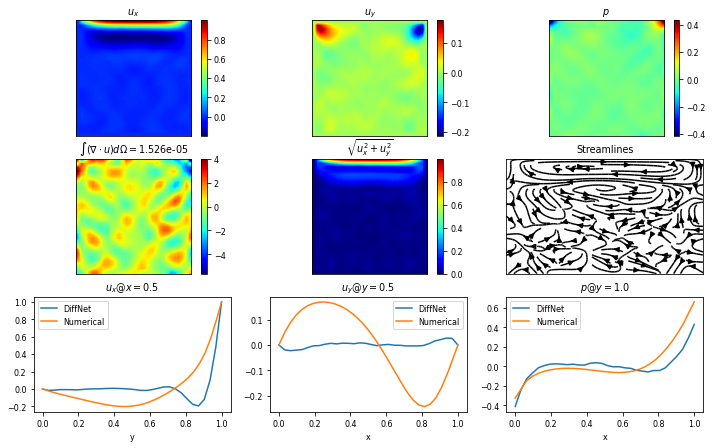

In [4]:
# Query
basecase.dataset[0]
inputs, forcing = basecase.dataset[0]
u, v, p, u_x, v_y = basecase.do_query(inputs, forcing)
u =   u.squeeze().detach().cpu()
v =   v.squeeze().detach().cpu()
p =   p.squeeze().detach().cpu()
u_x = u_x.squeeze().detach().cpu()
v_y = v_y.squeeze().detach().cpu()

# plot
plot_contours(basecase, u, v, p, u_x, v_y)

exact_solution -- LDC class called
forcing -- LDC class called


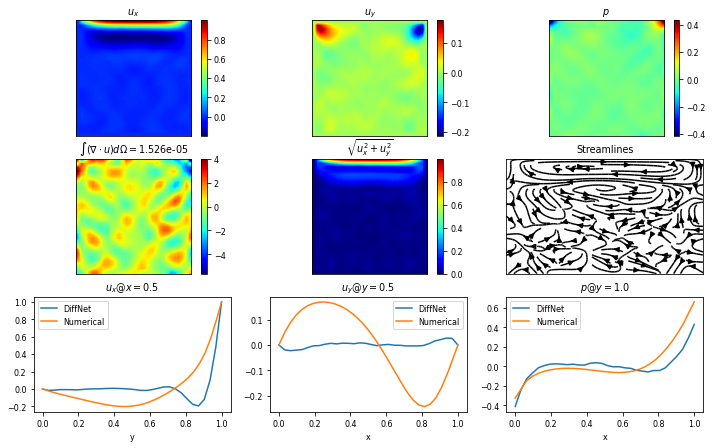

In [5]:
# separate query
version_id = 26
case_dir = './ns_ldc/version_'+str(version_id)
dataset = NS_LDC_Dataset(domain_size=domain_size)
net_u = torch.load(os.path.join(case_dir, 'net_u.pt'))
net_v = torch.load(os.path.join(case_dir, 'net_v.pt'))
net_p = torch.load(os.path.join(case_dir, 'net_p.pt'))
equation = NS_LDC((net_u, net_v, net_p), dataset, domain_size=domain_size, batch_size=1, fem_basis_deg=1)
# Query
inputs, forcing = basecase.dataset[0]
u, v, p, u_x, v_y = basecase.do_query(inputs, forcing)
u =   u.squeeze().detach().cpu()
v =   v.squeeze().detach().cpu()
p =   p.squeeze().detach().cpu()
u_x = u_x.squeeze().detach().cpu()
v_y = v_y.squeeze().detach().cpu()

# plot
plot_contours(basecase, u, v, p, u_x, v_y)

In [6]:
torch.set_printoptions(precision=10)

def calc_tau(h_tuple, adv_tuple, visco):
    '''
    values input to this function should be detached
    from the computation graph
    '''
    hx, hy = h_tuple
    u, v = adv_tuple

    g = torch.tensor([2./hx, 2./hy])
    G = torch.tensor([[4./hx**2, 0.], [0., 4./hy**2]])
    Cinv = 36.
    # assume regular grid
    adv_part = G[0,0] * u**2 + G[1,1] * v**2
    diffusion_part = Cinv* visco**2 * (G[0,0]**2 + G[1,1]**2)
    # calc taum at GP
    temp = torch.sqrt(adv_part + diffusion_part)
    taum = 1. / temp
    # calc tauc at GP
    gg = g[0]**2 + g[1]**2
    tauc = temp / gg
    print("taum.shape = ", taum.shape)
    print("tauc.shape = ", tauc.shape)
    print("taum = ", taum)
    print("tauc = ", tauc)
    return taum, tauc

In [7]:
hx = hy = 1./63.
ux = uy = 0.
visco = 1./100.
tm, tc = calc_tau((hx, hy), (ux, uy), visco)

taum.shape =  torch.Size([])
tauc.shape =  torch.Size([])
taum =  tensor(0.0007423225)
tauc =  tensor(0.0424264073)


In [8]:
temp = torch.tensor([tm])
print(temp)

tensor([0.0007423225])
